# Classes clustering

In [15]:
# %load boiler_plate.py
# reload modules when they change
%load_ext autoreload
%autoreload 2

# Alow plotting
%matplotlib inline

# Import modules higher in folder hierarchy
import os
import sys
import logging

from imp import reload

reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%I:%M:%S')

def add_path(path):
    if path not in sys.path:
        sys.path.append(path)

## Load data

In [1]:
import pickle

In [2]:
with open("/data/video/dbpedia_tags.pickle", "rb") as handle:
    t2l = pickle.load(handle)

In [ ]:
from collections import namedtuple

# define tag named tuple
Tag = namedtuple('Tag', ['id', 'name', 'description', 'labels'], verbose=True)

# load data
with open("/data/video/tag_list.pickle", "rb") as handle:
    tags = pickle.load(handle)

## Data preprocessing

In [4]:
import nltk
import spacy
import re

from nltk.stem.snowball import SnowballStemmer
from stop_words import get_stop_words

In [5]:
# load spacy language model
nlp = spacy.load('en')

# load nltk's English stopwords as variable called 'stopwords'
stopwords = set(nltk.corpus.stopwords.words('english')+ get_stop_words('en') +["-PRON-"])

# load nltk's SnowballStemmer as variabled 'stemmer'
stemmer = SnowballStemmer("english")

In [6]:
def filer_tokens(tokens, filter_stopwords=True):
    filtered = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered.append(token)
    
    # remove stop words
    if filter_stopwords:
        filtered = [token for token in filtered if token not in stopwords]
            
    return filtered
    
def tokenize_and_stem(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = filer_tokens(tokens)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenize_only(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = filer_tokens(tokens)
    return filtered_tokens

def tokenize_and_lem(text):
    tokens = [token.lemma_ for token in nlp(text)]
    filtered_tokens = filer_tokens(tokens)
    return filtered_tokens

### Evaluate data preprocessing

In [7]:
example = "The Log Cabin Republicans (LCR) is an organization that works within the Republican Party to advocate equal rights for all Americans, including gays and lesbians in the United States. The group's constituency supports the Republican Party and advocates for the rights of gay and lesbian Americans. LCR is the only Republican organization dedicated to representing the interests of LGBT Americans and their allies."

print(example, "\n")

print(" ".join(tokenize_only(example)), "\n")
print(" ".join(tokenize_and_stem(example)), "\n")
print(" ".join(tokenize_and_lem(example)), "\n")

The Log Cabin Republicans (LCR) is an organization that works within the Republican Party to advocate equal rights for all Americans, including gays and lesbians in the United States. The group's constituency supports the Republican Party and advocates for the rights of gay and lesbian Americans. LCR is the only Republican organization dedicated to representing the interests of LGBT Americans and their allies. 

log cabin republicans lcr organization works within republican party advocate equal rights americans including gays lesbians united states group 's constituency supports republican party advocates rights gay lesbian americans lcr republican organization dedicated representing interests lgbt americans allies 

log cabin republican lcr organ work within republican parti advoc equal right american includ gay lesbian unit state group 's constitu support republican parti advoc right gay lesbian american lcr republican organ dedic repres interest lgbt american alli 

log cabin republ

## TF-IDF and document similarity

In [8]:
import numpy as np

# Cluster only on descriptions
descriptions = [tag.description for tag in tags.values()]

# Cluster only on labels
labels = [" ".join(tag.labels) for tag in tags.values()]

# Cluster on both
descriptions_and_labels = ["%s %s" % tup for tup in zip(descriptions, labels)]

# Names
names = [tag.name for tag in tags.values()]

from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=0.01,
                                   max_features=200000, stop_words='english', 
                                   use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,1))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(descriptions)
print(tfidf_matrix.shape)

# get terms
terms = tfidf_vectorizer.get_feature_names()

CPU times: user 5.7 s, sys: 4 ms, total: 5.7 s
Wall time: 5.7 s
(4517, 540)


## K-means clustering

In [200]:
import matplotlib.pyplot as plt

from collections import Counter 
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def barplot(clusters, y_offset = 1):
    x_labels, values = zip(*Counter(clusters).items())

    indexes = np.arange(len(x_labels))
    width = 0.5
    plt.figure(figsize=(20, 5))
    plt.bar(indexes, values, width)
    plt.xticks(indexes, x_labels)
    
    for x, y in zip(indexes, values):
        plt.text(x - 0.5*width, y + y_offset, str(y))
    
    plt.show()
    
def print_top(km, terms, frame, ntop_words = 15, n_labels = 15):
    print("Top terms per cluster:")
    #sort cluster centers by proximity to centroid
    order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

    for i in range(km.n_clusters):
        top_words = [terms[i] for i in order_centroids[i, :ntop_words]]
        sample_labels = frame.ix[i]['names'][:n_labels].values

        print("Cluster %d" % i)
        print('WORDS: %s' % ', '.join(top_words))
        print("LABEL NAMES: %s" % ", ".join(sample_labels))
        print()

def elbow(X, point = 30, K = list(range(2, 50, 2))):
    KM = []
    for index, k in enumerate(K):
        logging.info("[%d] Fitting k-means for k=%d" % (index, k))
        KM.append(KMeans(n_clusters=k).fit(X))

    centroids = [k.cluster_centers_ for k in KM]

    D_k = [cdist(X.toarray(), cent, 'euclidean') for cent in centroids]
    cIdx = [np.argmin(D,axis=1) for D in D_k]
    dist = [np.min(D,axis=1) for D in D_k]
    avgWithinSS = [sum(d)/X.shape[0] for d in dist]

    # Total with-in sum of square
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(X.toarray())**2)/X.shape[0]
    bss = tss-wcss
    expVar = bss/tss*100
    
    # Silhouette scores
    scores = [silhouette_score(X, km.labels_, metric='euclidean') for km in KM]
    
    # Select colosest index to K
    kIdx = np.argmin((np.array(K) - point)**2)

    def plot(ax, data, ylabel, 
             xlabel = 'Number of clusters', 
             title = 'Elbow for KMeans clustering'):
        ''' Helper  function'''
        ax.plot(K, data, 'b*-')
        ax.plot(K[kIdx], data[kIdx], marker='o', markersize=12, 
                markeredgewidth=2, markeredgecolor='r', 
                markerfacecolor='None')

        ax.grid(True)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_title(title)
        

    # elbow curve
    fig = plt.figure(figsize=(15, 5))
    
    ax1 = plt.subplot(131)
    ax2 = plt.subplot(132)
    ax3 = plt.subplot(133)
    
    plot(ax1, avgWithinSS, 'Average within-cluster sum of squares')
    plot(ax2, expVar, 'Percentage of variance explained')
    plot(ax3, scores, "Silouette for K-means cell's behaviour")

    plt.tight_layout()

01:40:05 INFO:[0] Fitting k-means for k=5
01:40:16 INFO:[1] Fitting k-means for k=10
01:40:27 INFO:[2] Fitting k-means for k=25
01:40:36 INFO:[3] Fitting k-means for k=30
01:40:46 INFO:[4] Fitting k-means for k=40
01:40:55 INFO:[5] Fitting k-means for k=50
01:41:05 INFO:[6] Fitting k-means for k=70
01:41:16 INFO:[7] Fitting k-means for k=90
01:41:29 INFO:[8] Fitting k-means for k=100
01:41:43 INFO:[9] Fitting k-means for k=150
01:41:59 INFO:[10] Fitting k-means for k=200
01:42:17 INFO:[11] Fitting k-means for k=250
01:42:38 INFO:[12] Fitting k-means for k=300
01:43:00 INFO:[13] Fitting k-means for k=400


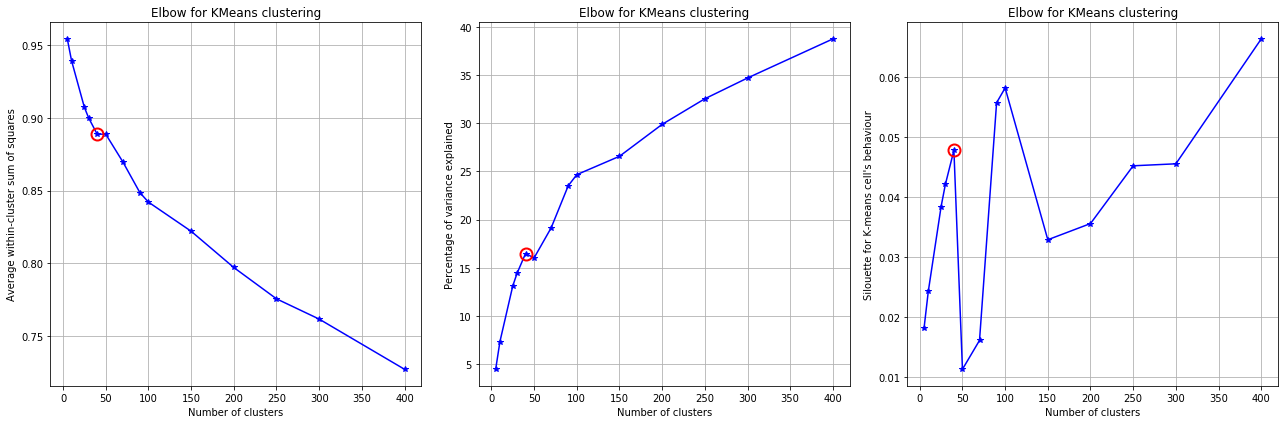

In [137]:
elbow(tfidf_matrix, point = 40, K = [5, 10, 25, 30, 40, 50, 70, 90, 100, 150, 200, 250, 300, 400])

### Train optimal k-means

In [138]:
NUM_CLUSTERS = 40

In [139]:
km = KMeans(n_clusters=NUM_CLUSTERS)

%time km.fit(tfidf_matrix)

CPU times: user 8.54 s, sys: 16 ms, total: 8.55 s
Wall time: 8.56 s


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=40, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

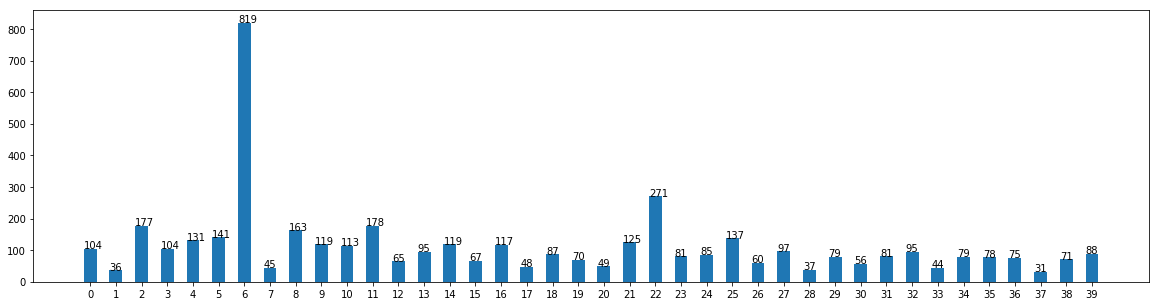

In [156]:
clusters = km.labels_.tolist()
barplot(clusters)

In [141]:
import pandas as pd

# Create dataframe for easy data handling
data = { 'names': names, 'descriptions': descriptions_and_labels, 'labels': labels}

frame = pd.DataFrame(data, index = [clusters] , columns = ['names', 'descriptions', 'labels'])

In [142]:
# eye-ball clustering result
print_top(km, terms, frame, ntop_words = 20)

Top terms per cluster:
Cluster 0
WORDS: law, govern, state, agenc, feder, depart, unit, respons, protect, act, servic, legal, power, nation, congress, u.s., person, execut, general, right
LABEL NAMES: No Child Left Behind Act, Sales tax, Abortion law, Fire department, Federal Communications Commission, Law enforcement, Trump Model Management, Montgomery County Police Department, Internal Revenue Service, Lobbying, Major Crimes, Separation of church and state, Anti-discrimination law, Local government, United States Department of Homeland Security

Cluster 1
WORDS: song, music, singl, record, singer-songwrit, album, cover, releas, artist, 's, musician, version, video, written, popular, origin, american, debut, produc, known
LABEL NAMES: Kanye West, National anthem, Videos, Lyrics, Cover version, Songwriter, America the Beautiful, Rick Astley, Harvey Fierstein, Eye of the Tiger, Feel Good, Music videos, Sara Bareilles, Musical theatre, The Wizard of Oz

Cluster 2
WORDS: seri, televis, am

# Hierarchical document clustering

In [157]:
from sklearn.model_selection import StratifiedShuffleSplit

In [56]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import ward, dendrogram

In [217]:
def sample(df, n, seed = 42):
    ''' Wrapper to perform stratified sampling '''
    split = StratifiedShuffleSplit(n_splits=1, test_size=n/len(df), random_state=seed)
    
    for _, index in split.split(df, df.index):  
        return df.iloc[index]

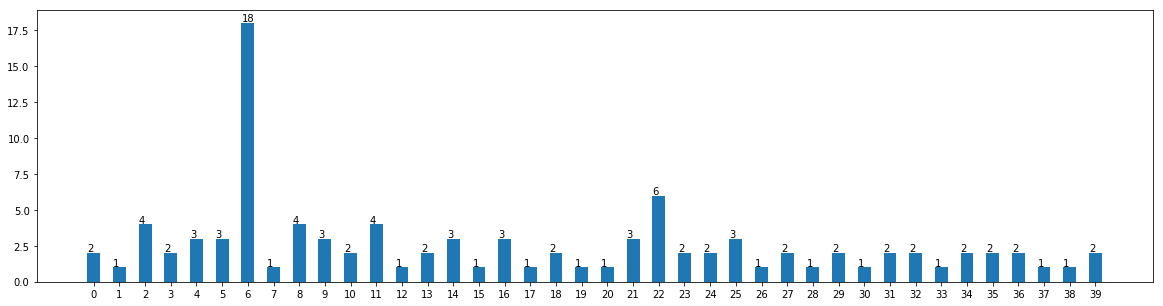

In [222]:
n = 100

sampled_ = sample(frame, n, seed=1)

tfidf_matrix_sampled = tfidf_vectorizer.transform(sampled_['descriptions'])
linkage_matrix = ward(1 - cosine_similarity(tfidf_matrix_sampled))

# well, i guess I should use stratified sampling
barplot(sampled_.index, y_offset = 0.1)

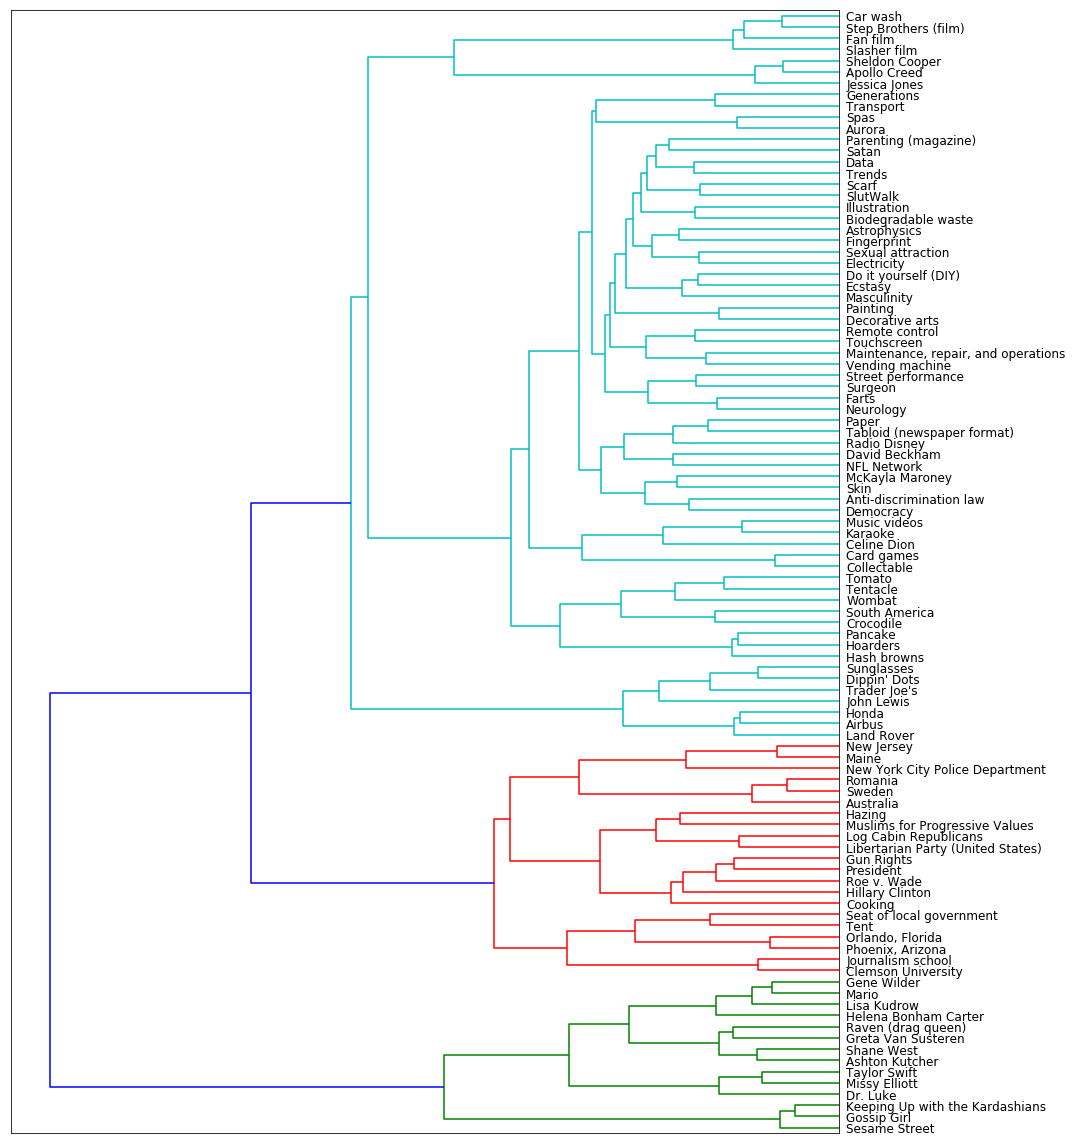

In [223]:
fig, ax = plt.subplots(figsize=(15, n / 6.25)) # set size
ax = dendrogram(
    linkage_matrix, 
    truncate_mode='mlab',
    orientation="left", 
    labels=sampled_.names.values, 
    leaf_font_size=12.,);
plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

# Latent Dirichlet Allocation

In [225]:
NUM_TOPICS = 100

In [224]:
from gensim import corpora, models, similarities 

texts = [tokenize_and_stem(text) for text in descriptions]

#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=1, no_above=0.8)

03:05:20 INFO:adding document #0 to Dictionary(0 unique tokens: [])
03:05:20 INFO:built Dictionary(18133 unique tokens: ['samoa', 'consortium', 'thermodynam', 'shrove', 'wick']...) from 4517 documents (total 168387 corpus positions)
03:05:20 INFO:discarding 0 tokens: []...
03:05:20 INFO:keeping 18133 tokens which were in no less than 1 and no more than 3613 (=80.0%) documents
03:05:20 INFO:resulting dictionary: Dictionary(18133 unique tokens: ['samoa', 'consortium', 'thermodynam', 'shrove', 'barbado']...)


## BoW Corpus

In [226]:
#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in texts]

In [ ]:
lda = models.LdaMulticore(
    corpus,
    num_topics=NUM_TOPICS,
    id2word=dictionary, passes=20)

In [228]:
topics_matrix = lda.show_topics(formatted=False, num_words=10, num_topics=NUM_TOPICS)
topics_matrix = [b for (a, b) in topics_matrix]
topics_matrix = np.array(topics_matrix)

for index, row in enumerate(topics_matrix, 1):
    print("Words for topic %d" % index)
    print(" | ".join(["{0} {1:.3f}".format(word, float(weight)) for (word, weight) in row]))
    print()

Words for topic 1
's 0.009 | use 0.009 | ancient 0.009 | race 0.009 | term 0.008 | hors 0.007 | product 0.007 | greek 0.006 | versac 0.006 | sinc 0.005

Words for topic 2
's 0.010 | includ 0.008 | relationship 0.007 | squirrel 0.007 | languag 0.006 | seri 0.005 | famili 0.005 | anim 0.005 | form 0.004 | also 0.004

Words for topic 3
art 0.008 | also 0.008 | american 0.008 | harvard 0.007 | common 0.006 | hybrid 0.006 | known 0.006 | whale 0.005 | school 0.005 | 's 0.005

Words for topic 4
use 0.010 | 's 0.008 | includ 0.008 | video 0.005 | social 0.005 | may 0.005 | protest 0.005 | group 0.005 | camera 0.004 | tan 0.004

Words for topic 5
book 0.011 | world 0.010 | carnegi 0.009 | includ 0.008 | guitar 0.008 | record 0.008 | 's 0.006 | form 0.005 | technolog 0.005 | children 0.005

Words for topic 6
comput 0.026 | graphic 0.018 | imag 0.011 | warcraft 0.011 | use 0.010 | 2d 0.010 | game 0.008 | may 0.008 | perform 0.008 | 3d 0.007

Words for topic 7
gay 0.019 | transgend 0.011 | christ

In [229]:
## Interactive visualisation
import pyLDAvis.gensim
vis = pyLDAvis.gensim.prepare(lda, corpus, dictionary, mds='mmds')
pyLDAvis.display(vis)

## TF-IDF Corpus

In [230]:
#create TF-IDF model
tfidf = models.TfidfModel(corpus)

#create corpus
corpus_tfidf = tfidf[corpus]

03:19:17 INFO:collecting document frequencies
03:19:17 INFO:PROGRESS: processing document #0
03:19:17 INFO:calculating IDF weights for 4517 documents and 18132 features (137252 matrix non-zeros)


In [ ]:
lda_tfidf = models.LdaMulticore(
    corpus_tfidf, 
    num_topics=NUM_TOPICS, 
    id2word=dictionary, passes=20)

In [232]:
## Interactive visualisation
import pyLDAvis.gensim
vis = pyLDAvis.gensim.prepare(lda_tfidf, corpus_tfidf, dictionary, mds='mmds')
pyLDAvis.display(vis)

## Topic based clustering

In [233]:
from gensim.matutils import corpus2dense

def transform_document(text, dictionary,  model, f = tokenize_and_stem, n = NUM_TOPICS):
    tokens = tokenize_and_stem(text) 
    doc = dictionary.doc2bow(tokens)
    dense = corpus2dense([model[doc]], n)
    return dense.T